# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.228435,False,-5.717738
1,-3.003768,False,-7.057605
2,0.108753,False,1.422536
3,-0.791985,False,-1.524991
4,-2.897733,False,-5.088577
...,...,...,...
995,-1.484495,False,-1.908192
996,0.190978,True,5.846923
997,-0.436201,False,-0.381625
998,0.526986,True,5.633316


<AxesSubplot:xlabel='v0'>

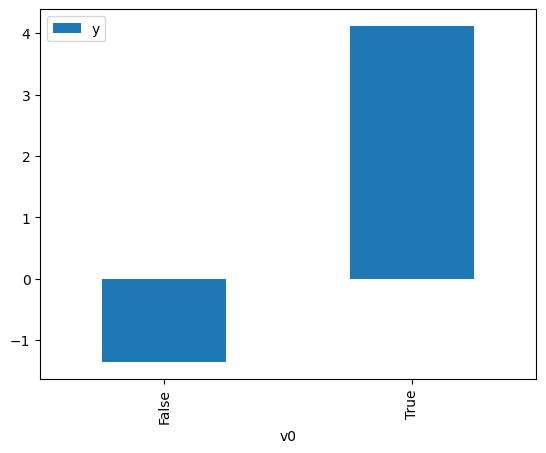

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

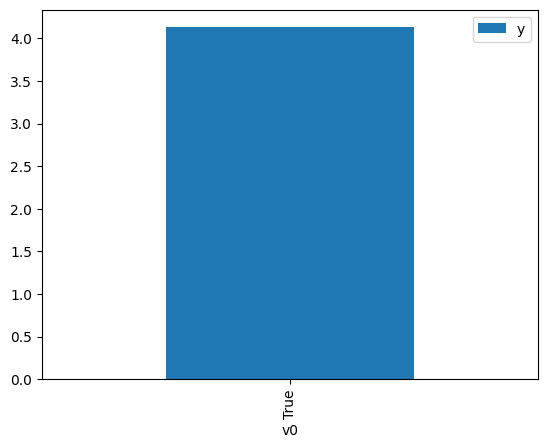

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.148031,False,0.875857,0.452595,2.209481
1,-0.600254,False,0.804159,0.793209,1.260701
2,-0.274073,False,0.665439,0.662723,1.508925
3,-2.808617,False,-6.992017,0.997194,1.002814
4,-0.319423,False,-0.390810,0.683187,1.463728
...,...,...,...,...,...
995,-0.007980,False,-1.414139,0.532393,1.878311
996,-0.115737,False,0.010407,0.586797,1.704166
997,-1.042557,False,-2.186134,0.904775,1.105247
998,-0.543355,False,-1.303044,0.773415,1.292968


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.512708,True,1.909793,0.038582,25.918873
1,-1.658949,True,0.506007,0.028873,34.633887
2,-0.818655,True,1.517149,0.142794,7.003085
3,0.699361,True,5.398955,0.789323,1.266909
4,0.666927,True,3.703586,0.778049,1.285266
...,...,...,...,...,...
995,-1.658949,True,0.506007,0.028873,34.633887
996,-0.015469,True,4.786290,0.463786,2.156169
997,-0.840291,True,3.210501,0.137449,7.275446
998,-0.881453,True,3.088680,0.127744,7.828180


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              7271.
Date:                Tue, 23 Aug 2022   Prob (F-statistic):                        0.00
Time:                        12:26:45   Log-Likelihood:                         -1401.8
No. Observations:                1000   AIC:                                      2808.
Df Residuals:                     998   BIC:                                      2817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9373      0.026     74.164      0.000       1.886       1.989
x2             4.9980      0.058     86.753      0.000       4.885       5.111
==============================================================================
Omnibus:                        9.879   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.478
Skew:                          -0.036   Prob(JB):                     0.000718
Kurtosis:                       3.585   Cond. No.                         2.22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""